# Image Compression and Generation using Variational Autoencoders in Python

### Prerequisites

- Intermediate-level knowledge of Python 3 (dealing with images and vector maths is useful)
- Exposure to PyTorch usage
- Basic understanding of Autoencoders and Generative Models

### Project Outline

**Task 1**: Introduction (this section)

**Task 2**: Exploratory Data Analysis and Preprocessing

**Task 3**: Training/Validation Split

**Task 4**: Creating Data Loaders

**Task 5**: VAE Architecture and Model Creation

**Task 6**: Training Loop

**Task 7**: Results and Other Uses

## Task 1: Introduction

I will explain the VAE briefly, but for additional information, feel free to check out the following resources:

- [Resource 1: Blog Post](https://www.jeremyjordan.me/variational-autoencoders/)
- [Resource 2: Theory Post](https://ermongroup.github.io/cs228-notes/inference/variational/)
- [Resource 3: Lecture Video](https://www.youtube.com/watch?v=P78QYjWh5sM&feature=youtu.be)

In addition, our VAE model in PyTorch has been adapted from the official PyTorch implementation you can find in [this repo](https://github.com/pytorch/examples/tree/master/vae). Enjoy the project!

<img src="Images/vae.png">

In [32]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm.notebook import tqdm

import os
import shutil
import random
random.seed(5)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

In [4]:
epochs = 1000
batch_size = 64
torch.manual_seed(17)

## Task 2: Exploratory Data Analysis and Preprocessing

We use the computer-generated fonts of the [Character Font Images Data Set](http://archive.ics.uci.edu/ml/datasets/Character+Font+Images#).

In [5]:
def show_img(img):
    img = img.permute(1, 2, 0)
    if img.shape[2]==1:
        img = img.view(img.shape[0], img.shape[1])
    plt.title(f'Image has size {img.cpu().numpy().shape}')
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.show()

In [6]:
transforms_all = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor()
])

dummy_batch = torch.utils.data.DataLoader(
    datasets.ImageFolder('Font/all', transform=transforms.ToTensor()),
    batch_size=1, shuffle=True
    )

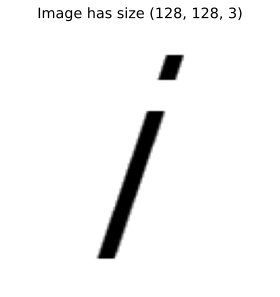

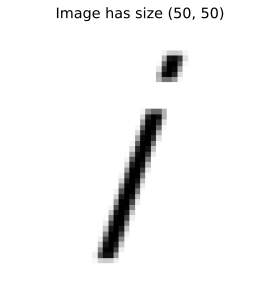

In [29]:
for batch in dummy_batch:
    original_image = batch[0][0]
    show_img(original_image)
    show_img(transforms_all(transforms.ToPILImage()(original_image)))
    break

## Task 3: Training/Validation Split

In [63]:
len(os.listdir('Font/all'))

63

In [12]:
folders = os.listdir('Font/all')

# ignore hidden files
folders = [folder for folder in folders if folder[0]!='.']

os.mkdir('Font/train')
os.mkdir('Font/val')

for folder in tqdm(folders):
    os.mkdir(f'Font/val/{folder}')
    os.mkdir(f'Font/train/{folder}')
    
    images = os.listdir(f'Font/all/{folder}')
    
    images = [image for image in images if image[0]!='.']
    
    random.shuffle(images)
    
    for image in images[:20]:
        shutil.copy(f'Font/all/{folder}/{image}', f'Font/val/{folder}/{image}')
        
    for image in images[20:]:
        shutil.copy(f'Font/all/{folder}/{image}', f'Font/train/{folder}/{image}')

FileExistsError: [Errno 17] File exists: 'Font/train'

In [64]:
len(os.listdir('Font/train/Sample001/')), len(os.listdir('Font/val/Sample001/'))

(996, 20)

## Task 4: Creating Data Loaders

In [14]:
transforms_set = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize(size=50),
    transforms.ToTensor(),
])

train_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('Font/train', transform=transforms_set),
    batch_size=batch_size, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    datasets.ImageFolder('Font/val', transform=transforms_set),
    batch_size=batch_size, shuffle=True
)

## Task 5: VAE Architecture and Model Creation

In [15]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # need to fill in dimensions here
    
        z = 32
        
        self.fc1 = nn.Linear(50*50, 1000)
        self.fc21 = nn.Linear(1000, z)
        self.fc22 = nn.Linear(1000, z)
        self.fc3 = nn.Linear(z, 1000)
        self.fc4 = nn.Linear(1000, 50*50)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        
        # don't forget forward pass re-index
        
        mu, logvar = self.encode(x.view(-1, 50*50))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [16]:
def loss_function(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 50*50), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [104]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
model = VAE().to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-3)

cuda


## Task 6: Training Loop

In [103]:
def evaluate(evaluate_data=val_loader):
    
    model.eval()
    
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):
            
            data = data.to(device)
            
            recon_batch, mu, logvar = model(data)
            val_loss += loss_function(recon_batch, data, mu, logvar).item()
            
            if i == 0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 50, 50)[:n]])
                save_image(comparison.cpu(),
                           'Results/reconstruction_' + str(epoch) + '.pdf', nrow=n)

    val_loss /= len(evaluate_data.dataset)
    return val_loss


def sample_latent_space(epoch):
    with torch.no_grad():
        
        sample = torch.randn(64, 32).to(device)
        sample = model.decode(sample).cpu()
        
        save_image(sample.view(64, 1, 50, 50),
                   'Results/sample_' + str(epoch) + '.pdf')

In [105]:
def train(epoch):

    model.train()
    train_loss = 0
    
    progress_bar = tqdm(train_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data, _ in progress_bar:
        
        data = data.to(device)
        
        optimizer.zero_grad()

        recon_batch, mu, logvar = model(data)
        
        loss = loss_function(recon_batch, data, mu, logvar)
        
        loss.backward()
        
        train_loss += loss.item()
        optimizer.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
    val_loss = evaluate(val_loader)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)
    
    if epoch%50==0:
        torch.save(model.state_dict(), f'Models/epoch_{epoch}.model')

In [106]:
epochs = 32

In [107]:
train_losses, val_losses = [], []
    
for epoch in range(1, epochs + 1):
    train(epoch)
    sample_latent_space(epoch)

np.savetxt(f'Models/training_losses_{epochs}.txt', np.array(train_losses), delimiter='\n')
np.savetxt(f'Models/validation_losses_{epochs}.txt', np.array(val_losses), delimiter='\n')

Epoch 001:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 001): 411.262
				====> Validation set loss: 322.961


Epoch 002:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 002): 304.016
				====> Validation set loss: 292.086


Epoch 003:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 003): 285.568
				====> Validation set loss: 280.087


Epoch 004:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 004): 276.810
				====> Validation set loss: 274.184


Epoch 005:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 005): 271.914
				====> Validation set loss: 270.502


Epoch 006:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 006): 268.798
				====> Validation set loss: 273.706


Epoch 007:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 007): 266.219
				====> Validation set loss: 267.004


Epoch 008:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 008): 264.439
				====> Validation set loss: 263.831


Epoch 009:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 009): 262.941
				====> Validation set loss: 263.583


Epoch 010:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 010): 261.541
				====> Validation set loss: 264.459


Epoch 011:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 011): 260.273
				====> Validation set loss: 262.945


Epoch 012:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 012): 259.460
				====> Validation set loss: 260.396


Epoch 013:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 013): 258.540
				====> Validation set loss: 259.414


Epoch 014:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 014): 257.699
				====> Validation set loss: 260.140


Epoch 015:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 015): 257.078
				====> Validation set loss: 258.913


Epoch 016:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 016): 256.273
				====> Validation set loss: 257.329


Epoch 017:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 017): 255.682
				====> Validation set loss: 259.261


Epoch 018:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 018): 255.086
				====> Validation set loss: 257.644


Epoch 019:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 019): 254.782
				====> Validation set loss: 257.561


Epoch 020:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 020): 254.286
				====> Validation set loss: 255.405


Epoch 021:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 021): 253.846
				====> Validation set loss: 254.913


Epoch 022:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 022): 253.013
				====> Validation set loss: 259.432


Epoch 023:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 023): 252.886
				====> Validation set loss: 254.806


Epoch 024:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 024): 252.375
				====> Validation set loss: 255.850


Epoch 025:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 025): 252.457
				====> Validation set loss: 254.841


Epoch 026:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 026): 251.853
				====> Validation set loss: 255.150


Epoch 027:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 027): 251.662
				====> Validation set loss: 255.470


Epoch 028:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 028): 251.281
				====> Validation set loss: 252.798


Epoch 029:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 029): 251.033
				====> Validation set loss: 255.019


Epoch 030:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 030): 250.751
				====> Validation set loss: 256.174


Epoch 031:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 031): 250.440
				====> Validation set loss: 253.583


Epoch 032:   0%|          | 0/965 [00:00<?, ?it/s]

Training set loss (average, epoch 032): 250.437
				====> Validation set loss: 254.204


In [95]:
np.savetxt(f'Models/training_losses_{epochs}.txt', np.array(train_losses), delimiter='\n')
np.savetxt(f'Models/validation_losses_{epochs}.txt', np.array(val_losses), delimiter='\n')

In [108]:
torch.save(model.state_dict(), f'Models/final_{epochs}.model')

## Task 7: Results and Other Uses

In [109]:
#loads trained model data.
train_losses = np.loadtxt(f'Models/training_losses_{epochs}.txt')
val_losses = np.loadtxt(f'Models/validation_losses_{epochs}.txt')

In [111]:
#loads pre-trained model data.
train_losses = np.loadtxt('Presaved_Models/training_losses.txt')
val_losses = np.loadtxt('Presaved_Models/validation_losses.txt')

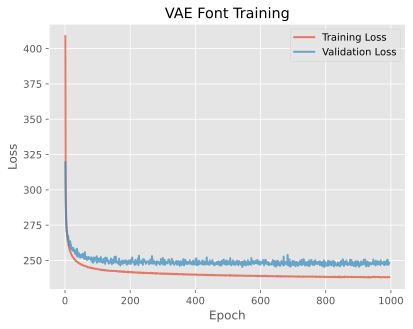

In [112]:
plt.plot(
    range(1, len(train_losses)+1), 
    train_losses,
    label='Training Loss',
    linewidth=2,
    alpha=0.7
)

plt.plot(
    range(1, len(val_losses)+1), 
    val_losses,
    label='Validation Loss',
    linewidth=2,
    alpha=0.7
)


plt.title('VAE Font Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
pass

In [50]:
model_test = VAE()

In [144]:
model_test.load_state_dict(torch.load('Presaved_Models/epoch_950.model',
                                 map_location=torch.device('cuda')))

<All keys matched successfully>

In [138]:
epochs = 32

In [139]:
model_test.load_state_dict(torch.load(f'Models/final_{epochs}.model',
                                 map_location=torch.device('cuda')))

<All keys matched successfully>

## This part is added by me to test and compare the two different models with epoch sizes 16 and 950. // Armağan

In [126]:
image_path = 'image.png'

In [145]:
image_path = 'S.png'

In [146]:
from PIL import Image


# Load the saved weights


# Set the model to evaluation mode
model_test.eval()

# Convert the image to a PyTorch tensor
image = Image.open(image_path).convert('L')  # Convert the image to grayscale


input_size = (50, 50)
image = image.resize(input_size)
image = np.array(image) / 255.0
image_tensor = torch.tensor(image, dtype=torch.float32).unsqueeze(0).view(1, -1)

# Perform inference/prediction
with torch.no_grad():
    reconstructed_image, _, _ = model_test(image_tensor)

print(reconstructed_image.shape)

# Convert the reconstructed image tensor back to a numpy array
reconstructed_image = reconstructed_image.view(1, 50, 50).numpy()

import matplotlib.pyplot as plt

# Convert the reconstructed image to the range [0, 1]
reconstructed_image = np.clip(reconstructed_image, 0, 1)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the reconstructed image
ax.imshow(reconstructed_image[0], cmap='gray')

# Remove the axes and labels
ax.axis('off')

# Save the figure as 'out.png'
plt.savefig('out.png', bbox_inches='tight', pad_inches=0)

# Close the figure
plt.close(fig)


torch.Size([1, 2500])


After 950 epochs: 
<img src="Presaved_Results/reconstruction_950.png">

After 950 epochs: 
<img src="Presaved_Results/sample_950.png">

### Alternative Font Reconstruction (2-D Latent Space)

After 1000 epochs: <img src="Presaved_Results/reconstruction_1000_2dim.png">

### CelebA Reconstructions with 500-D Latent Space

[CelebA Dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html)

After 100 epochs:
<img src="Celebs/reconstruction_100.png">

After 200 epochs:
<img src="Celebs/reconstruction_200.png">

After 300 epochs:
<img src="Celebs/reconstruction_300.png">

After 400 epochs:
<img src="Celebs/reconstruction_400.png">

After 500 epochs:
<img src="Celebs/reconstruction_500.png">

After 600 epochs:
<img src="Celebs/reconstruction_600.png">